In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import pandas as pd
from Personalities import (
    mbti_order,
    type_to_name,
    enne_order,
    mbti_replace,
    enne_replace,
    enne_exclude,
    mbti_exclude,
)
import re
from scipy import stats
import seaborn as sns

In [2]:
sns.set_theme("paper")
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [3]:
enne = pd.read_csv("Data\Enneagram_Full.csv", names=["user", "flair"])
mbti = pd.read_csv("Data\mbti_Full.csv", names=["user", "flair"])
overlap = enne.merge(mbti, on="user").drop_duplicates("user")

In [4]:
def replace_match(overlap, col, reg, remove_last_char=False):
    match = overlap.loc[overlap[col].apply(lambda x: re.search(reg, x) is not None), col]
    if remove_last_char:
        isolator = lambda x: re.search(reg, x).group(0)[:-1]
    else:
        isolator = lambda x: re.search(reg, x).group(0)
    overlap.loc[match.index, col] = match.apply(isolator)
    return overlap

In [5]:
overlap = overlap[
    overlap["flair_x"].apply(lambda x: isinstance(x, str))
    & overlap["flair_y"].apply(lambda y: isinstance(y, str))
]

In [6]:
overlap["flair_x"].replace(enne_replace, inplace=True)
overlap["flair_y"].replace(mbti_replace, inplace=True)
for i in overlap[overlap["flair_x"].isin(enne_exclude)].index:
    overlap.drop(i, inplace=True)
for i in overlap[overlap["flair_y"].isin(mbti_exclude)].index:
    overlap.drop(i, inplace=True)
trigramms = lambda x: re.search(r"[1-9]{3}", x) is not None
for i in overlap.loc[overlap["flair_x"].apply(trigramms)].index:
    overlap.drop(i, inplace=True)

In [7]:
overlap = replace_match(overlap, "flair_x", r"[1-9]w[1-9]")
overlap = replace_match(overlap, "flair_x", r"[1-9] ", True)
overlap = replace_match(overlap, "flair_x", r"[1-9],", True)

In [8]:
ct = pd.crosstab(overlap["flair_x"], overlap["flair_y"])
ct = ct[mbti_order]
ct = ct.reindex(enne_order)

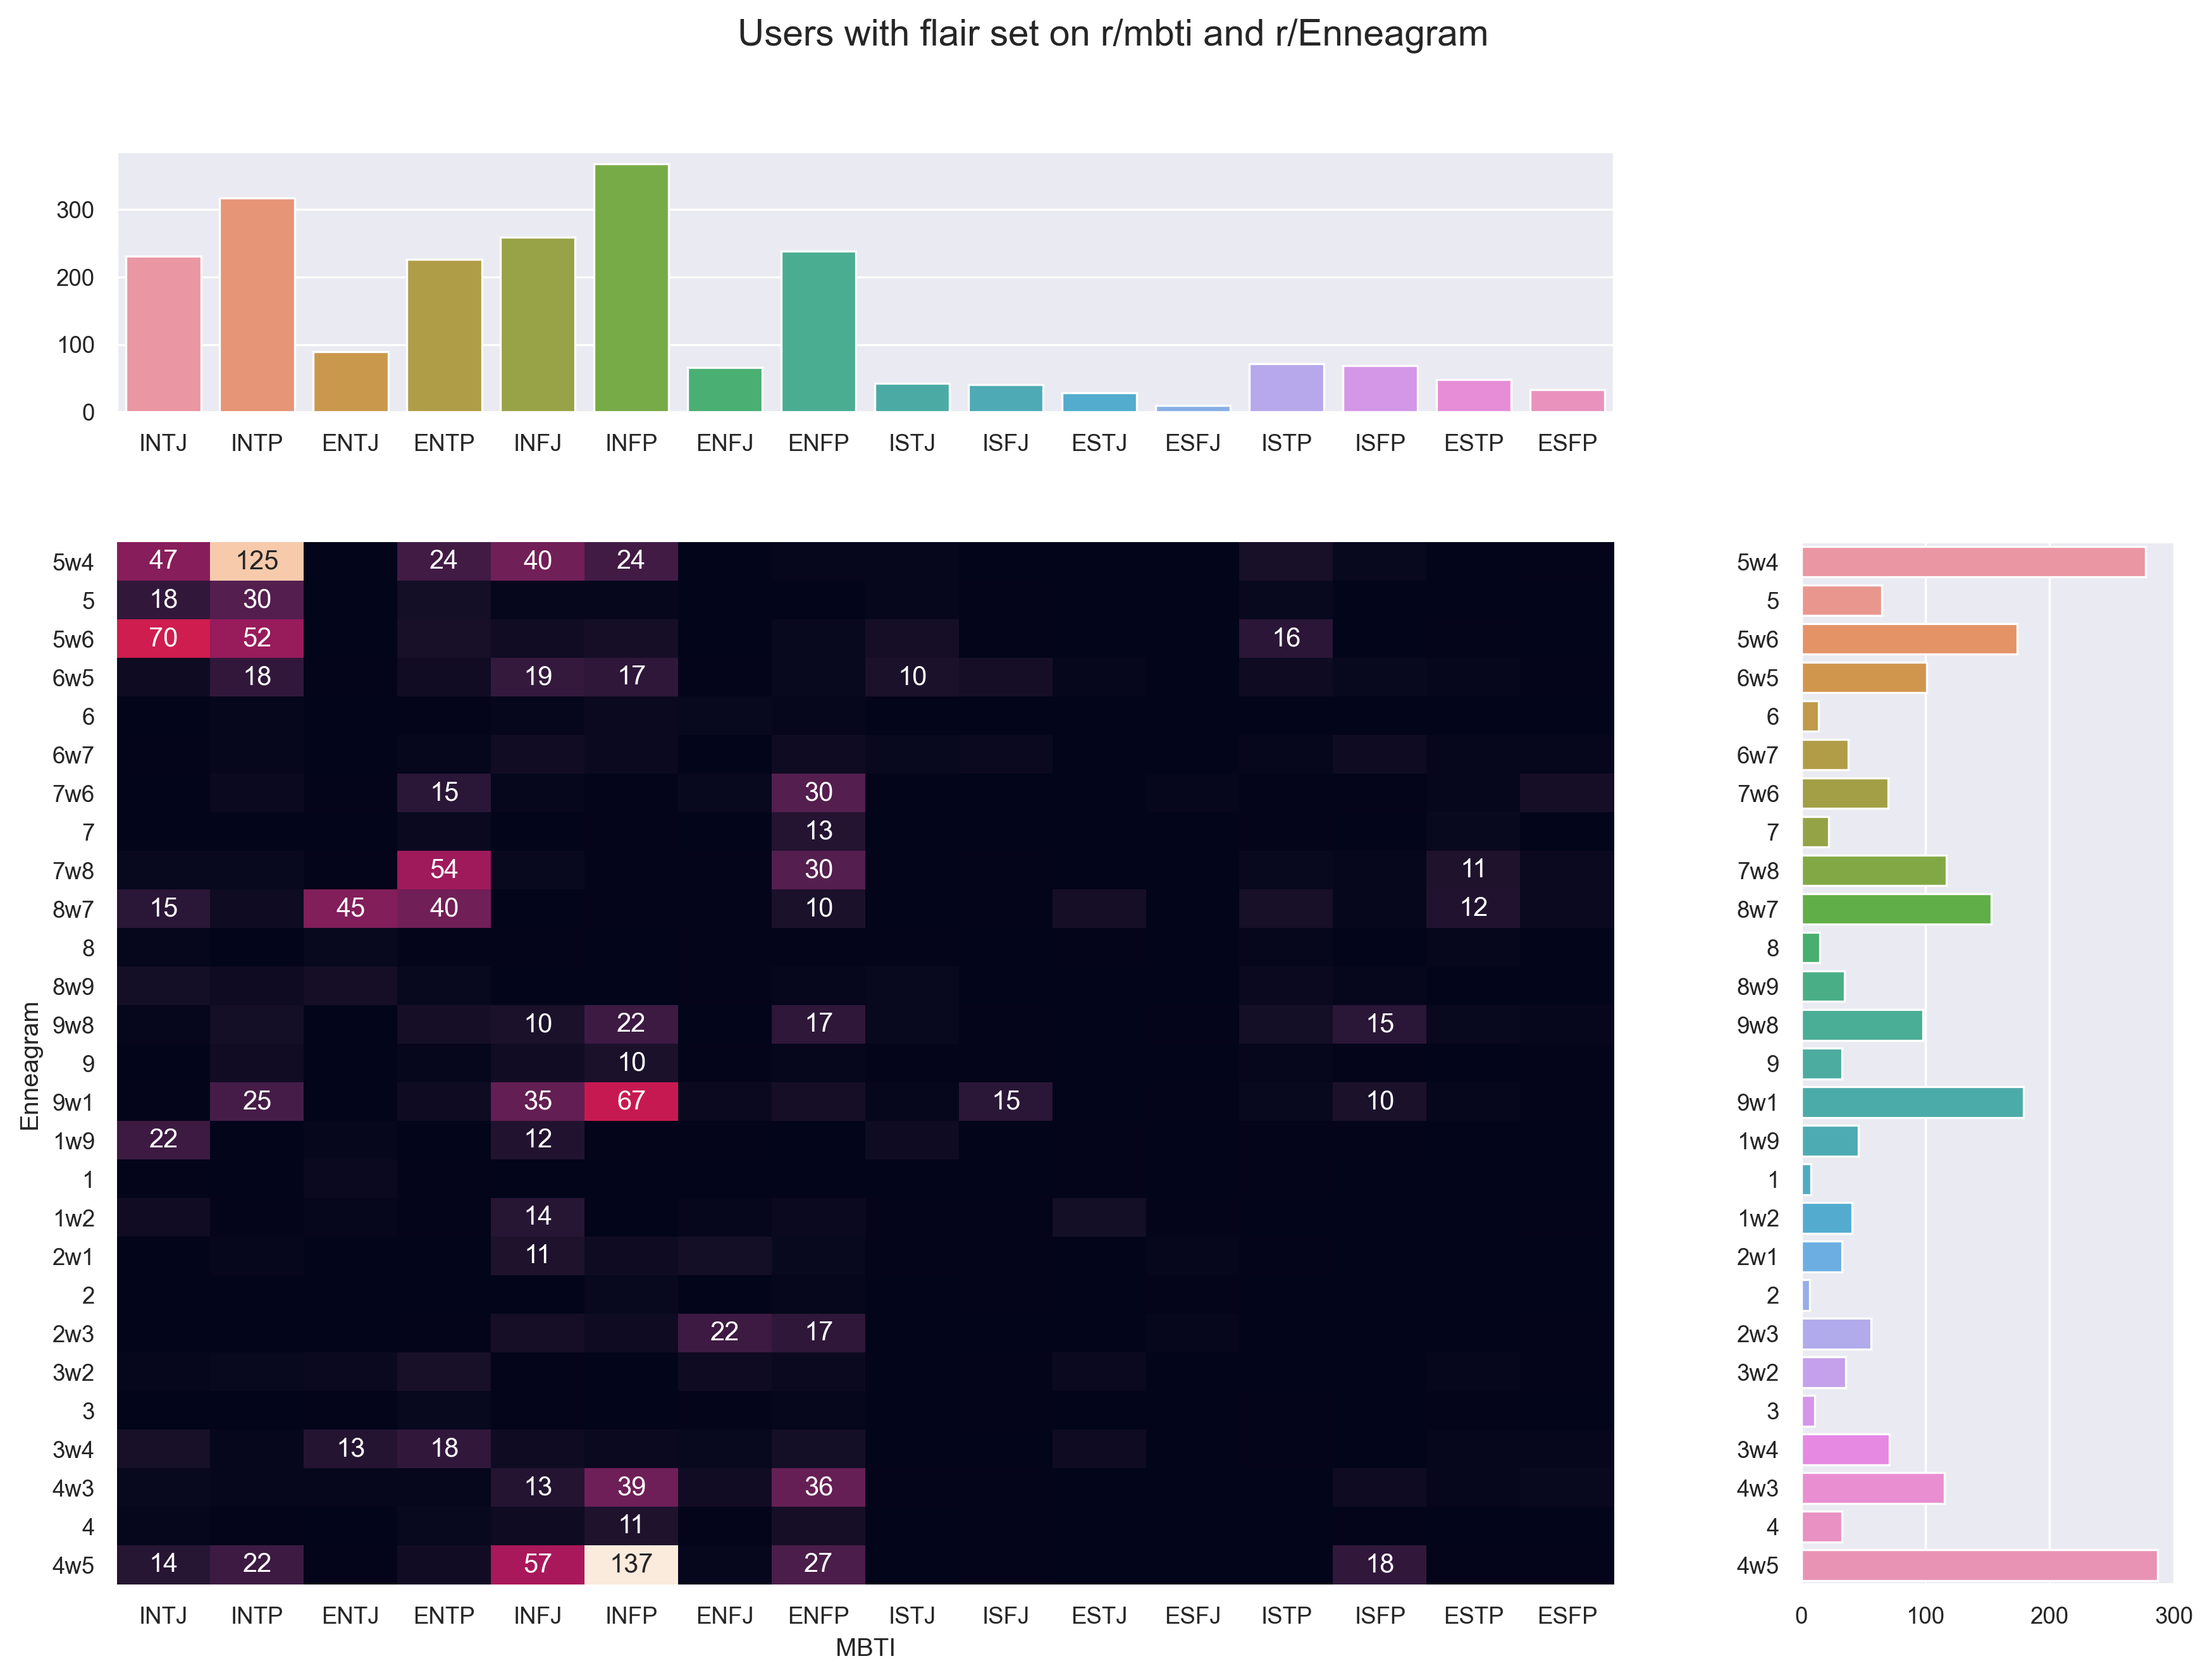

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(
    2,
    2,
    gridspec_kw={"width_ratios": [4, 1], "height_ratios": [1, 4]},
    num="Users with flair set on r/mbti and r/Enneagram",
)
fig.suptitle("Users with flair set on r/mbti and r/Enneagram", y=0.95, fontsize=14)
sns.heatmap(
    ct,
    annot=ct.applymap(lambda x: x if x >= 10 else ""),
    fmt="",
    ax=ax[1][0],
    cbar=False,
)
ax[1][0].set_yticks([x + 0.5 for x in list(range(27))])
ax[1][0].set_yticklabels(enne_order)
ax[1][0].set_ylabel("Enneagram")
ax[1][0].set_xlabel("MBTI")
ax[0][1].remove()
mbti_counts = overlap["flair_y"].value_counts().reindex(mbti_order)
sns.barplot(x=mbti_counts.index, y=mbti_counts, ax=ax[0][0])
ax[0][0].set_ylabel("")
enne_counts = overlap["flair_x"].value_counts().reindex(enne_order)
sns.barplot(x=enne_counts, y=enne_counts.index, ax=ax[1][1])
ax[1][1].set_xlabel("")
plt.show()

In [10]:
chi2, p, dof, expected = stats.chi2_contingency(ct)
underfive = sum([sum([1 if y < 5 else 0 for y in x]) for x in expected])
underfive/=(27*16)
print(f"chi-squared test statistic: {chi2}")
print(f"p-value: {p}")
print(f"degrees of freedom: {dof}\n")
print(f"fraction of expected values with value under five: {underfive}")

chi-squared test statistic: 3214.9292865810066
p-value: 0.0
degrees of freedom: 390

fraction of expected values with value under five: 0.7291666666666666


In [11]:
overlap2 = overlap.copy()
overlap2.flair_x = overlap2.flair_x.apply(lambda x: x[0])
ct2 = pd.crosstab(overlap2["flair_x"], overlap2["flair_y"])
ct2

flair_y,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
flair_x,,,,,,,,,,,,,,,,
1,3,4,8,2,1,1,9,0,26,1,29,1,1,1,6,2
2,29,22,0,1,5,1,0,0,19,13,0,2,2,0,1,1
3,9,13,18,30,0,3,9,5,7,4,11,5,2,0,0,2
4,9,71,3,12,0,4,0,3,75,187,19,25,3,24,1,0
5,0,5,1,40,0,1,0,1,48,34,136,207,2,3,12,28
6,4,10,1,9,0,3,2,4,27,25,6,22,12,8,13,7
7,4,73,2,73,2,12,0,16,5,3,3,7,1,3,0,5
8,3,13,56,44,0,4,9,14,1,1,24,10,1,4,4,15
9,5,27,0,15,2,4,0,5,51,99,3,38,17,26,6,12


In [12]:
chi2, p, dof, expected = stats.chi2_contingency(ct2)
underfive = sum([sum([1 if y < 5 else 0 for y in x]) for x in expected])
underfive/=(27*16)
print(f"chi-squared test statistic: {chi2}")
print(f"p-value: {p}")
print(f"degrees of freedom: {dof}\n")
print(f"fraction of expected values with value under five: {underfive}")

chi-squared test statistic: 2475.565755525501
p-value: 0.0
degrees of freedom: 120

fraction of expected values with value under five: 0.12731481481481483


In [13]:
plt.rcParams['figure.figsize'] = [14, 9]
plt.rcParams['figure.dpi'] = 300

enne_base = enne.value_counts("flair").head(27)
enne_base = enne_base.reindex(enne_order)
enne_base -= enne_counts
enne_base_proc = pd.DataFrame(
    (enne_base / sum(enne_base)).values,
    index=enne_base.index,
    columns=["% users with flair"],
)
enne_base_proc["Type"] = "Just r/Enneagram"
enne_counts_proc = pd.DataFrame(
    (enne_counts / sum(enne_counts)).values,
    index=enne_counts.index,
    columns=["% users with flair"],
)
enne_counts_proc["Type"] = "r/mbti and r/Enneagram"
enne_comb = pd.concat([enne_base_proc, enne_counts_proc])

In [14]:
def change_height(ax, new_value):
    for patch in ax.patches:
        if a := patch.get_alpha():
            nv = 1
            patch.set_linewidth(0)
            # c = patch.get_color()
            # patch.set_edgecolor(c)
        else:
            nv = new_value
        current_height = patch.get_height()
        diff = current_height - nv
        patch.set_height(nv)
        patch.set_y(patch.get_y() + diff * 0.5)

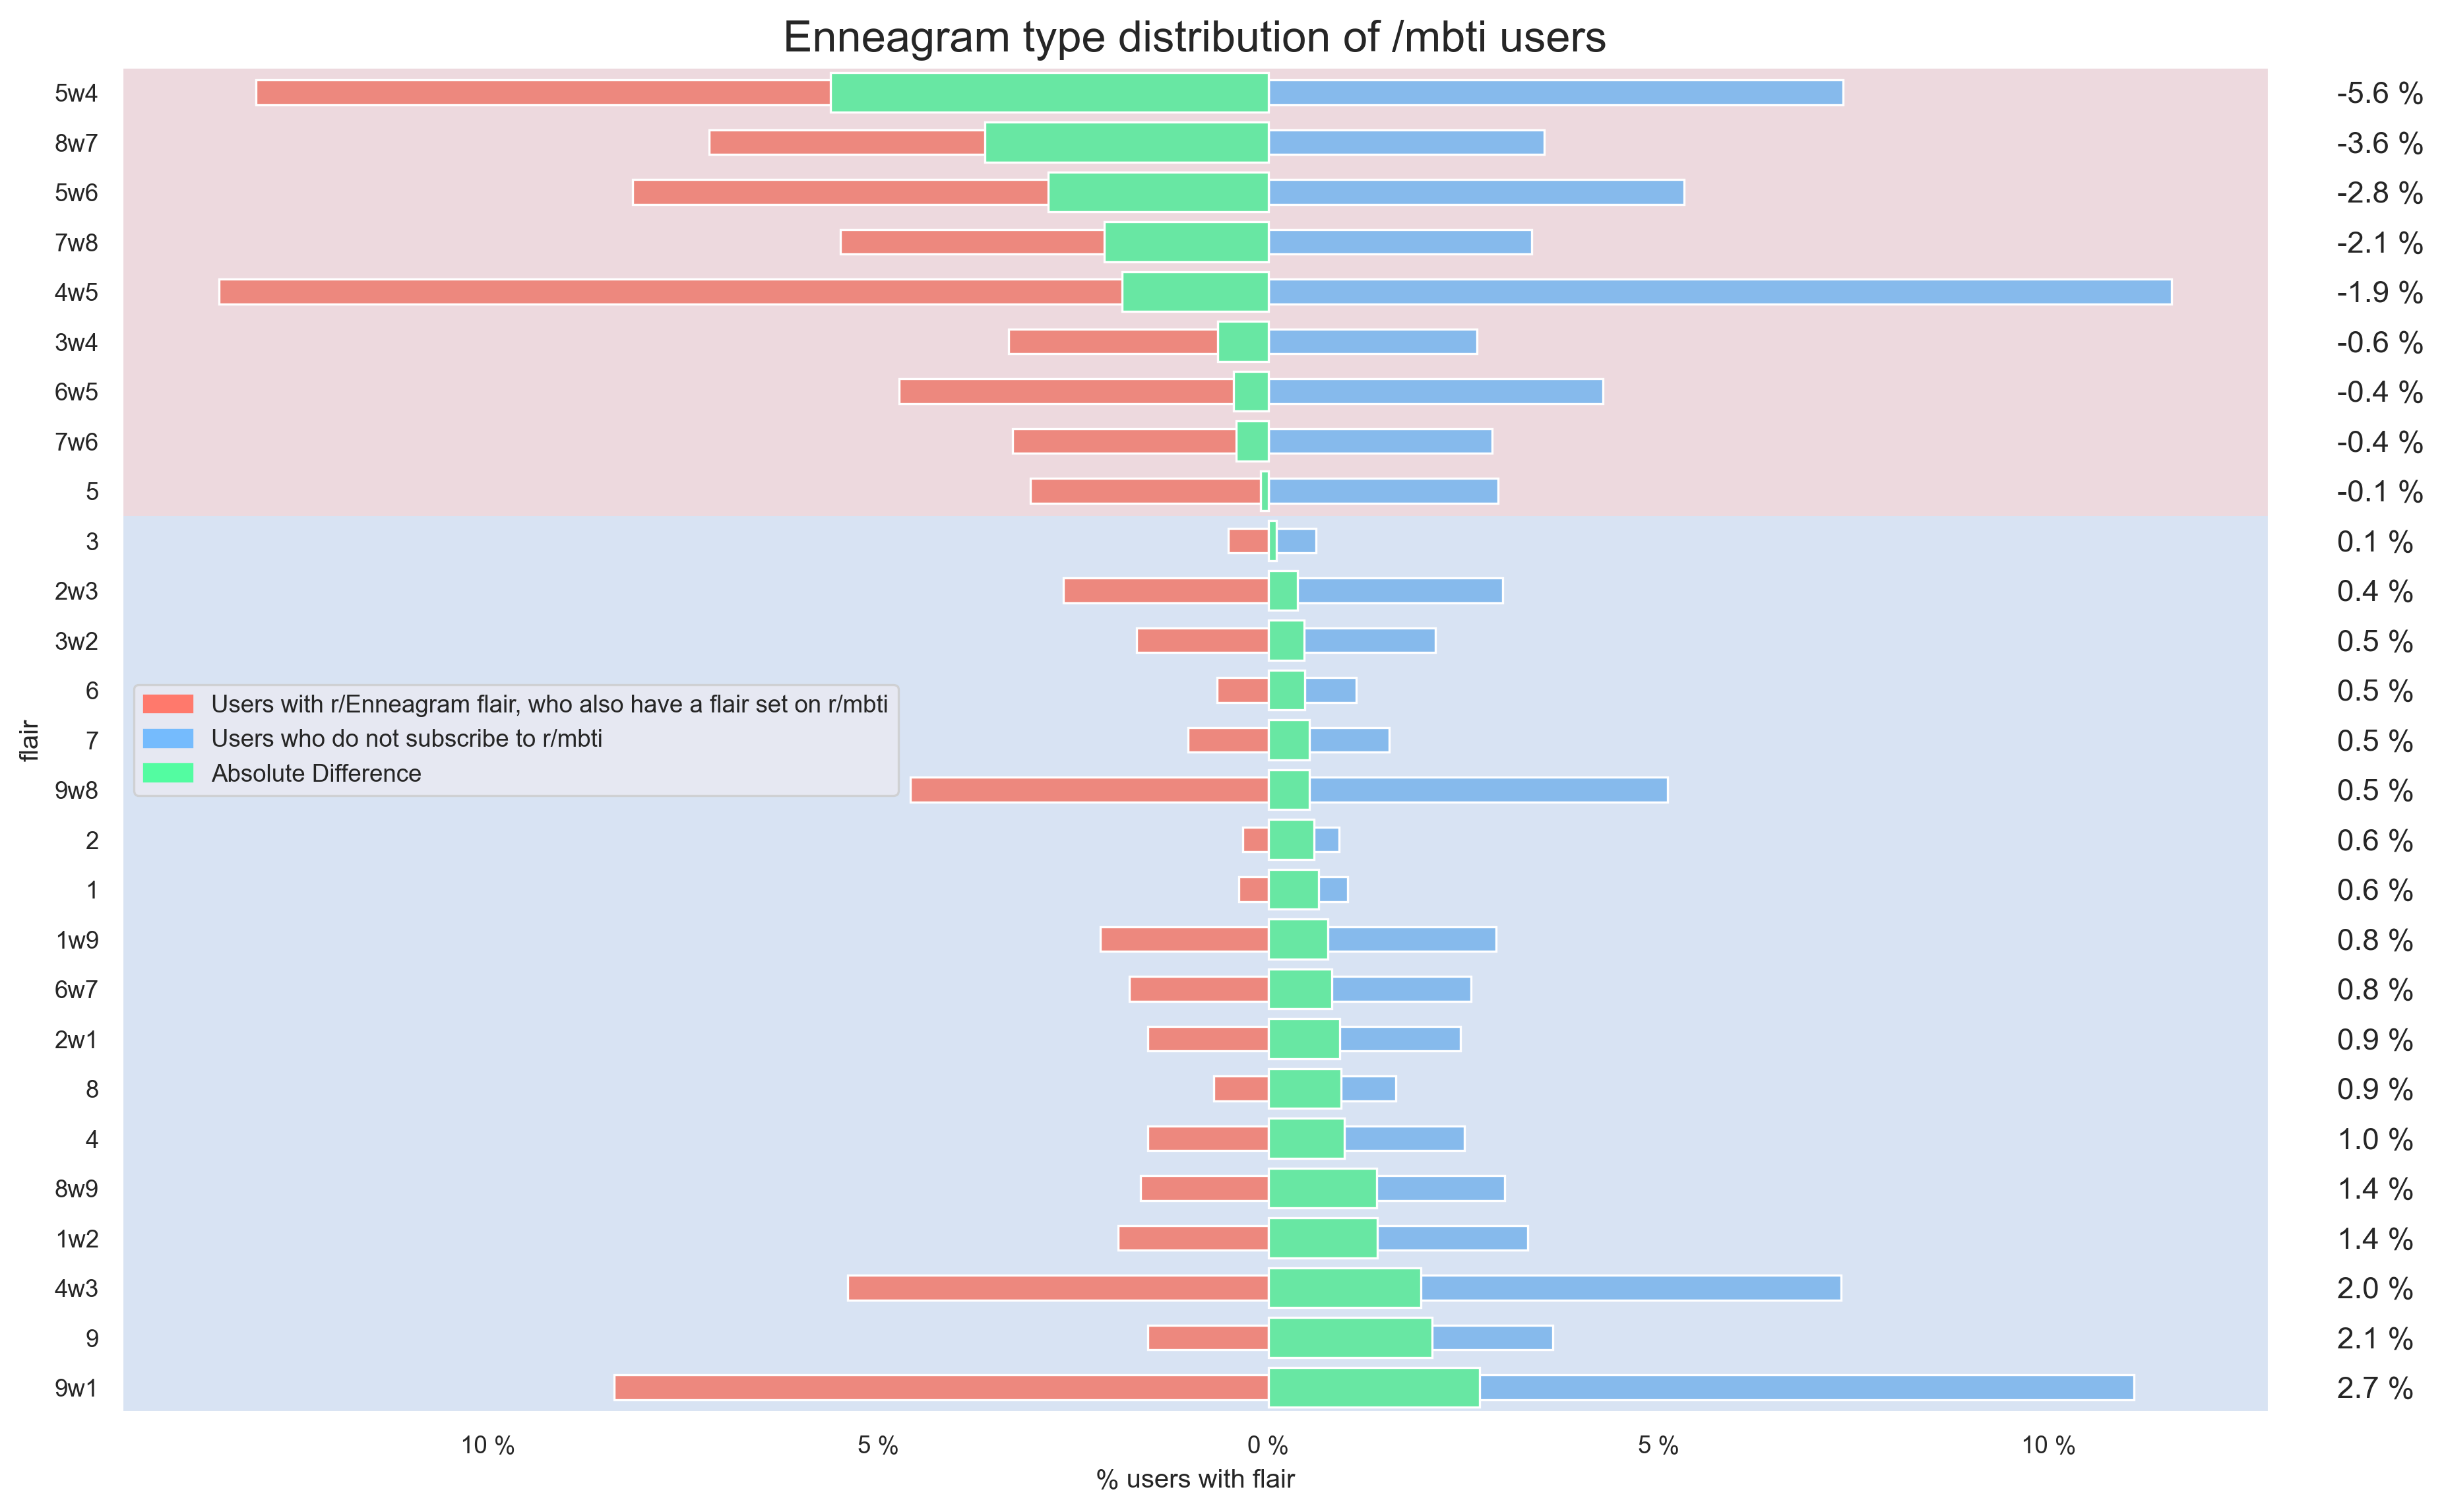

In [15]:
diff = enne_base_proc["% users with flair"] - enne_counts_proc["% users with flair"]
diff = diff.reindex(diff.sort_values().index)
enne_base_proc = enne_base_proc.reindex(diff.sort_values().index)
enne_counts_proc = enne_counts_proc.reindex(diff.sort_values().index)

ax = sns.barplot(x=diff, y=diff.sort_values().index)
for patch in ax.patches:
    if patch.get_width() < 0:
        patch.set_color("#ff796c")
    else:
        patch.set_color("#75bbfd")
    patch.set_alpha(0.15)
    patch.set_x(-1)
    patch.set_width(2)
ax = sns.barplot(
    x=enne_base_proc["% users with flair"], y=diff.sort_values().index, color="#75bbfd"
)
ax = sns.barplot(
    x=enne_counts_proc["% users with flair"] * -1,
    y=diff.sort_values().index,
    color="#ff796c",
)
change_height(ax, 0.5)
diff = enne_base_proc["% users with flair"] - enne_counts_proc["% users with flair"]
ax = sns.barplot(x=diff, y=diff.sort_values().index, color="#53fca1")
ax.xaxis.set_major_formatter(lambda x, y: f"{abs(x*100):.0f} %")
for patch in ax.patches:
    if patch.get_height() == 0.8:
        width = patch.get_width()
        y = patch.get_y() + 0.6
        if width > 0:
            x = patch.get_x() + width
            # t.set_bbox(dict(facecolor="#75bbfd", alpha=0.5, edgecolor="#75bbfd"))
        else:
            x = 0
            # t.set_bbox(dict(facecolor="#ff796c", alpha=0.5, edgecolor="#ff796c"))
        # plt.text(.12, -.8, "Difference", font="Arial", fontsize=11)
        t = ax.text(0.137, y, f"{(width*100):.1f} %", fontsize=11)
plt.legend(
    [
        matplotlib.patches.Patch(color="#ff796c"),
        matplotlib.patches.Patch(color="#75bbfd"),
        matplotlib.patches.Patch(color="#53fca1"),
    ],
    ["Users with r/Enneagram flair, who also have a flair set on r/mbti", "Users who do not subscribe to r/mbti", "Absolute Difference"],
    loc=0,
)
plt.title("Enneagram type distribution of /mbti users", fontsize=16)
ax.grid(False)
plt.show()

In [16]:
plt.rcParams['figure.figsize'] = [14, 9]
plt.rcParams['figure.dpi'] = 300

mbti_base = mbti.value_counts("flair").head(27)
mbti_base = mbti_base.reindex(mbti_order)
mbti_base -= mbti_counts
mbti_base_proc = pd.DataFrame(
    (mbti_base / sum(mbti_base)).values,
    index=mbti_base.index,
    columns=["% users with flair"],
)
mbti_base_proc["Type"] = "Just r/mbti"
mbti_counts_proc = pd.DataFrame(
    (mbti_counts / sum(mbti_counts)).values,
    index=mbti_counts.index,
    columns=["% users with flair"],
)
mbti_counts_proc["Type"] = "r/mbti and r/Enneagram"
mbti_comb = pd.concat([mbti_base_proc, mbti_counts_proc])

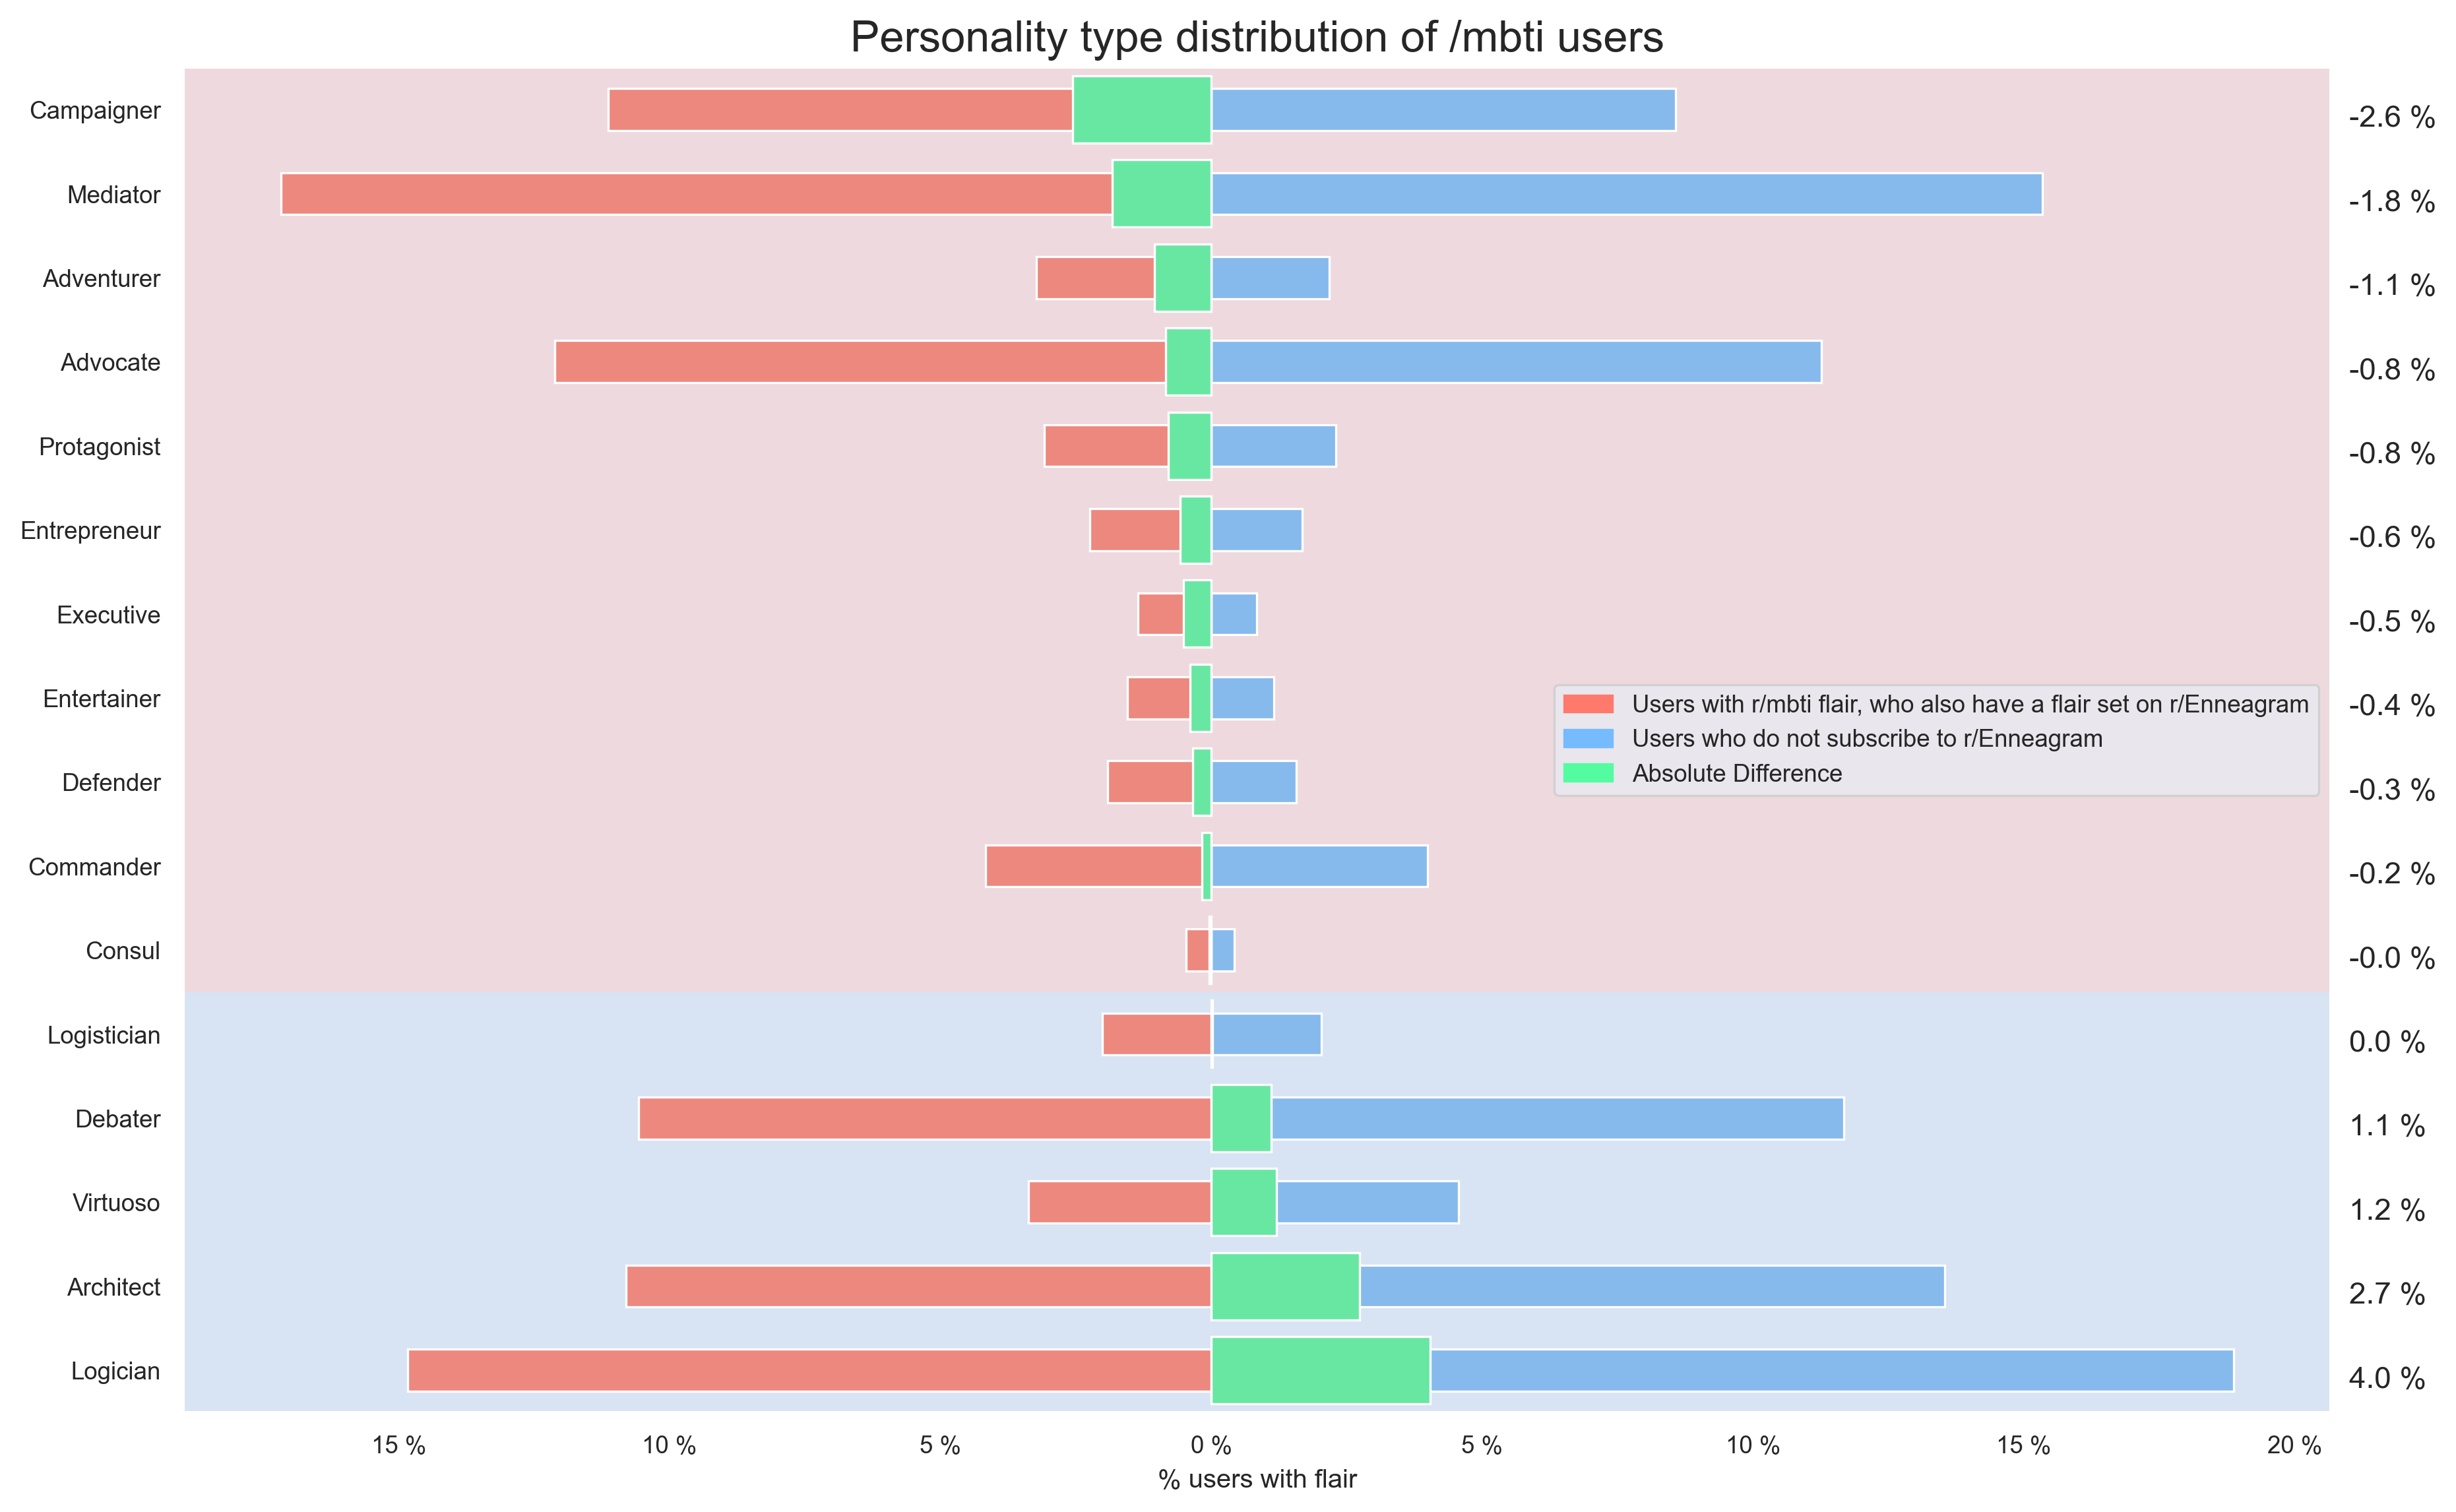

In [17]:
diff = mbti_base_proc["% users with flair"] - mbti_counts_proc["% users with flair"]
diff = diff.reindex(diff.sort_values().index)
y_labels = [type_to_name[x] for x in diff.index]
mbti_base_proc = mbti_base_proc.reindex(diff.sort_values().index)
mbti_counts_proc = mbti_counts_proc.reindex(diff.sort_values().index)

ax = sns.barplot(x=diff, y=y_labels)
for patch in ax.patches:
    if patch.get_width() < 0:
        patch.set_color("#ff796c")
    else:
        patch.set_color("#75bbfd")
    patch.set_alpha(0.15)
    patch.set_x(-1)
    patch.set_width(2)
ax = sns.barplot(
    x=mbti_base_proc["% users with flair"], y=y_labels, color="#75bbfd"
)
ax = sns.barplot(
    x=mbti_counts_proc["% users with flair"] * -1,
    y=y_labels,
    color="#ff796c",
)
change_height(ax, 0.5)
diff = mbti_base_proc["% users with flair"] - mbti_counts_proc["% users with flair"]
ax = sns.barplot(x=diff, y=y_labels, color="#53fca1")
ax.xaxis.set_major_formatter(lambda x, y: f"{abs(x*100):.0f} %")
for patch in ax.patches:
    if patch.get_height() == 0.8:
        width = patch.get_width()
        y = patch.get_y() + 0.6
        if width > 0:
            x = patch.get_x() + width
            # t.set_bbox(dict(facecolor="#75bbfd", alpha=0.5, edgecolor="#75bbfd"))
        else:
            x = 0
            # t.set_bbox(dict(facecolor="#ff796c", alpha=0.5, edgecolor="#ff796c"))
        # plt.text(.12, -.8, "Difference", font="Arial", fontsize=11)
        t = ax.text(0.21, y, f"{(width*100):.1f} %", fontsize=11)
plt.legend(
    [
        matplotlib.patches.Patch(color="#ff796c"),
        matplotlib.patches.Patch(color="#75bbfd"),
        matplotlib.patches.Patch(color="#53fca1"),
    ],
    ["Users with r/mbti flair, who also have a flair set on r/Enneagram", "Users who do not subscribe to r/Enneagram", "Absolute Difference"],
    loc=0,
)
plt.title("Personality type distribution of /mbti users", fontsize=16)
ax.grid(False)
plt.show()